# Generating the UNSW-NB15 sub-datasets

In [1]:
# Imports
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras import datasets, layers, models
from keras.callbacks import EarlyStopping  # Keras callbacks
from keras.layers import Dense  # Keras layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

# Disable warns
pd.options.mode.chained_assignment = None  # default='warn'

# Set seaborn theme to the plots
sns.set()

2025-03-24 10:54:31.773830: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 10:54:31.817573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-24 10:54:31.832103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-24 10:54:31.835992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 10:54:31.875556: I tensorflow/core/platform/cpu_feature_guar

To generate the datasets, download the different UNSW-NB15 CSV files and put it into the datasets directory.

In [21]:
# Reading datasets
dfs = []
for i in range(1,5):
    path = '../datasets/UNSW-NB15_{}.csv'  # There are 4 input csv files
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df

# This csv file contains names of all the features
df_col = pd.read_csv('../datasets/NUSW-NB15_features.csv', encoding='ISO-8859-1')
# Making column names lower case, removing spaces
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())
# Renaming our dataframe with proper column names
all_data.columns = df_col['Name']
del df_col


/tmp/ipykernel_7386/3747723619.py:5: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header = None))
/tmp/ipykernel_7386/3747723619.py:5: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header = None))


In [22]:
# We don't have "normal" values for "attack_cat", so we must fill Null values with "normal"
all_data['attack_cat'] = all_data.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())


In [23]:
all_data['attack_cat'] = all_data['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

In [24]:
all_data['ct_flw_http_mthd'] = all_data.ct_flw_http_mthd.fillna(value=0)

In [25]:
all_data['is_ftp_login'] = (all_data.is_ftp_login.fillna(value=0)).astype(int)

In [26]:
# Removing empty space and converting it to numerical
all_data['ct_ftp_cmd'] = all_data['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

In [27]:
all_data['is_ftp_login'] = np.where(all_data['is_ftp_login']>1, 1, all_data['is_ftp_login'])

In [28]:
# removing all the "-" and replacing those with "None"
all_data['service'] = all_data['service'].apply(lambda x:"None" if x=="-" else x)

In [29]:
# Select features
all_data=all_data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur', 'label', 'attack_cat']]

In [30]:
all_data.to_csv('../datasets/UNSW-NB15.csv', index=False)

In [31]:
# This csv file contains the preprocessed UNSW-NB15 dataset
data = pd.read_csv('../datasets/UNSW-NB15.csv', low_memory=False)

In [32]:
# Selecting attack type in different dataframes
normal = data.loc[data['attack_cat'] == 'normal', :]
generic = data.loc[data['attack_cat'] == 'generic', :]
exploits = data.loc[data['attack_cat'] == 'exploits', :]
fuzzers = data.loc[data['attack_cat'] == 'fuzzers', :]
dos = data.loc[data['attack_cat'] == 'dos', :]
reconnaissance = data.loc[data['attack_cat'] == 'reconnaissance', :]
analysis = data.loc[data['attack_cat'] == 'analysis', :]
backdoor = data.loc[data['attack_cat'] == 'backdoor', :]
shellcode = data.loc[data['attack_cat'] == 'shellcode', :]
worms = data.loc[data['attack_cat'] == 'worms', :]    

In [33]:
def balance_dataset(data=data):
    attacks = data.loc[data['label'] == 1, :]
    n_attacks = len(attacks)
    no_attacks_all = data.loc[data['label'] == 0, :]
    no_attacks = no_attacks_all.sample(n=n_attacks, random_state=1)
    data = pd.concat([attacks, no_attacks])
    return data

# UNSW-NB15-Basic


In [34]:
# Creating the basic dataset
basic = pd.concat([normal, dos, exploits, generic, reconnaissance])

In [35]:
all_0, all_1 = basic['label'].value_counts()[0]*100 / len(basic.index), basic['label'].value_counts()[1]*100 / len(basic.index)

print("In Basic dataset: there are {} % of normal traffic and {} % of attacks".format(all_0, all_1))

In Basic dataset: there are 88.42832717577149 % of normal traffic and 11.57167282422851 % of attacks


In [36]:
# Balancing the dataset to obtain 50/50% attacks/normal traffic
basic=balance_dataset(basic)

In [37]:
all_0, all_1 = basic['label'].value_counts()[0]*100 / len(basic.index), basic['label'].value_counts()[1]*100 / len(basic.index)

print("In balanced Basic dataset: there are {} % of normal traffic and {} % of attacks".format(all_0, all_1))

In balanced Basic dataset: there are 50.0 % of normal traffic and 50.0 % of attacks


I0000 00:00:1742795137.002108    7386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742795137.002244    7386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742795137.083925    7386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742795137.084067    7386 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

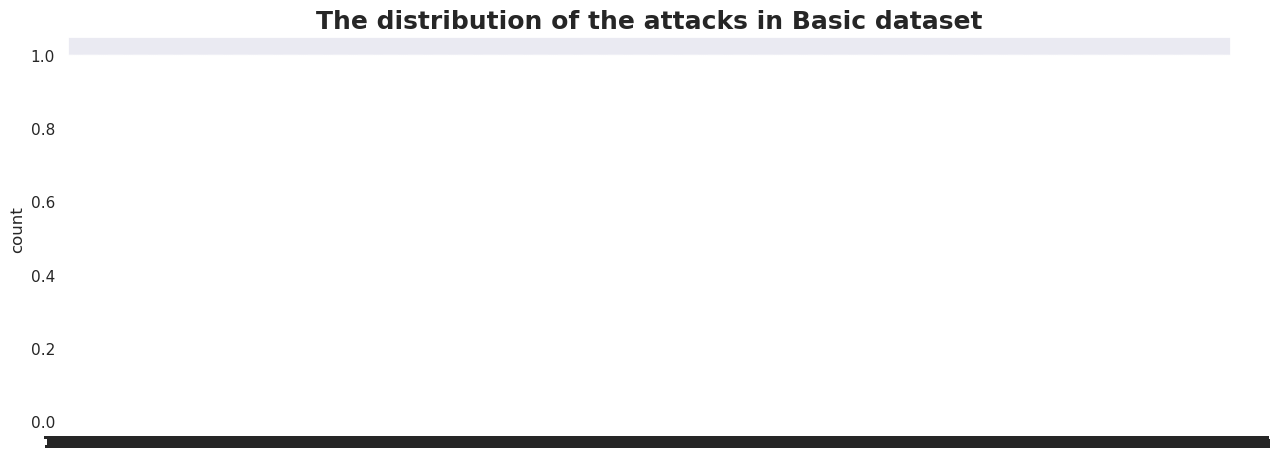

In [38]:
with tf.device('/GPU:0'):  # Use GPU 0    
    # Plotting target label distribution
    plt.figure(figsize=(15,5))
    sns.set_theme(style="darkgrid")
    sns.countplot(basic['label'])
    plt.title('The distribution of the attacks in Basic dataset', weight='bold', fontsize='18')
    plt.xticks(weight='bold', fontsize=12)
    plt.show()

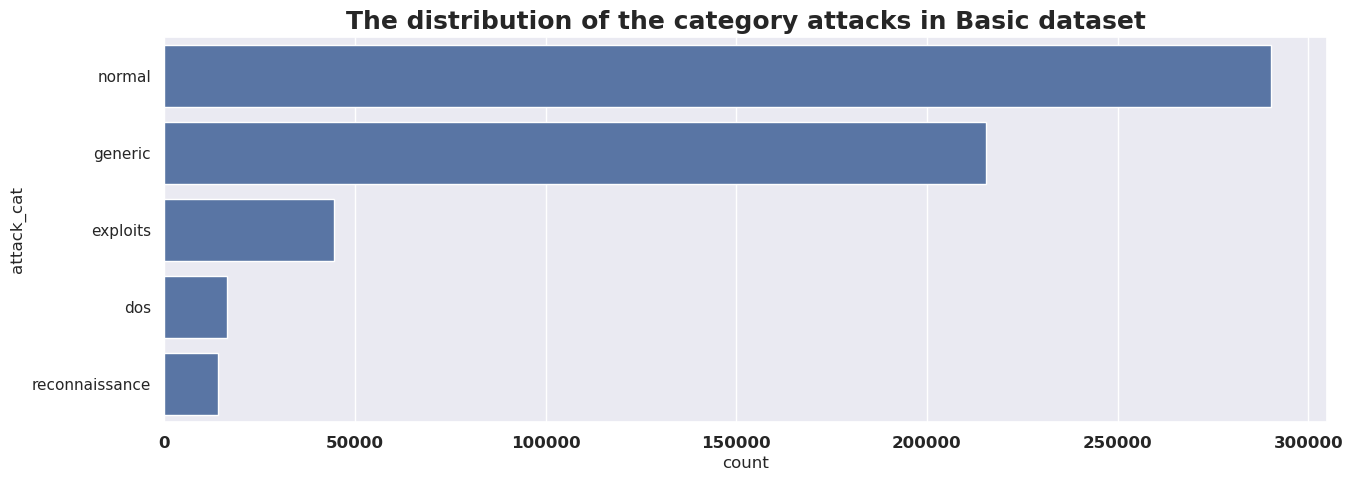

In [39]:
# Plotting attack category distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(basic['attack_cat'], order = basic['attack_cat'].value_counts().index)
plt.title('The distribution of the category attacks in Basic dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [40]:
# Shuffle dataframe
basic=basic.sample(frac=1)

In [41]:
# Generate UNSW-NB15-Train-Basic
n=basic.shape[0]
basic_train = basic.iloc[:round(0.75*n),:] # 75% of dataset
basic_test = basic.iloc[round(0.75*n):,:] # 25% of dataset

## UNSW-NB15-Train-Basic


In [42]:
all_0, all_1 = basic_train['label'].value_counts()[0]*100 / len(basic_train.index), basic_train['label'].value_counts()[1]*100 / len(basic_train.index)

print("In Train-Basic dataset: there are {} % of normal traffic and {} % of attacks".format(all_0, all_1))

In Train-Basic dataset: there are 50.07175347114592 % of normal traffic and 49.92824652885408 % of attacks


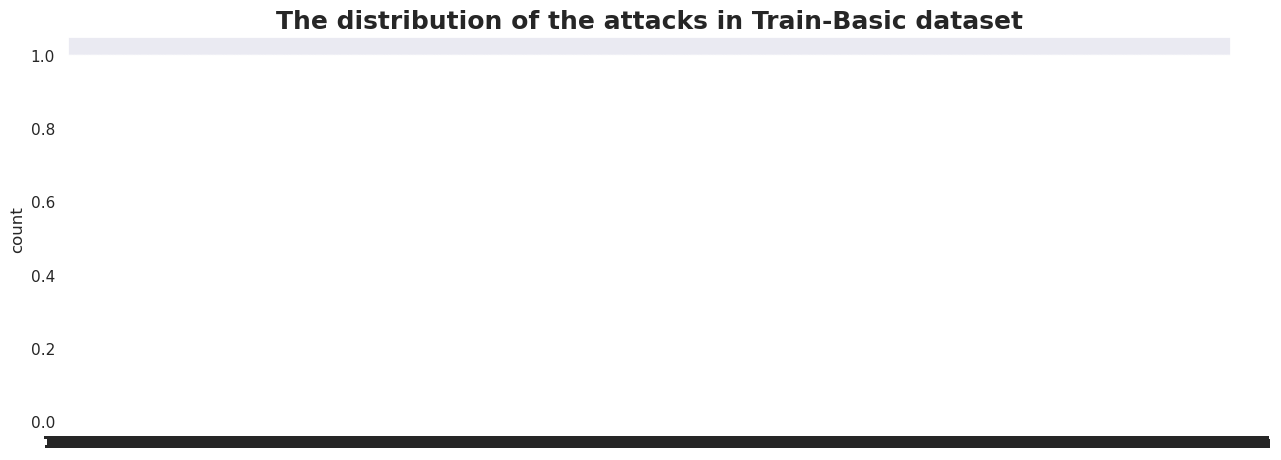

In [43]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(basic_train['label'])
plt.title('The distribution of the attacks in Train-Basic dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

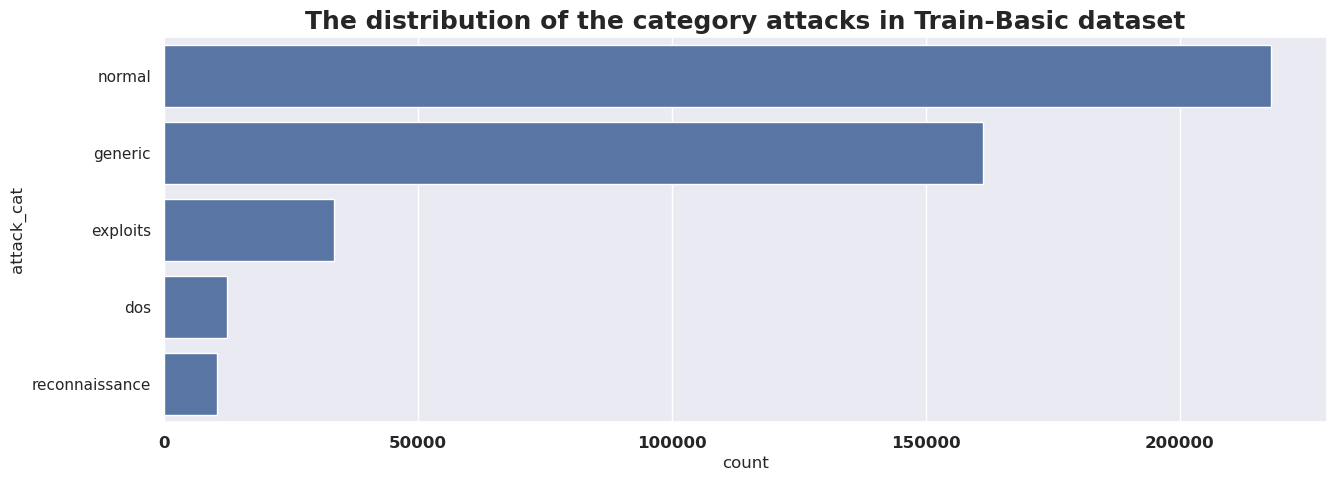

In [44]:
# Plotting attack category distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(basic_train['attack_cat'], order = basic_train['attack_cat'].value_counts().index)
plt.title('The distribution of the category attacks in Train-Basic dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [45]:
basic_train['attack_cat'].value_counts()

attack_cat
normal            218072
generic           161287
exploits           33369
dos                12341
reconnaissance     10450
Name: count, dtype: int64

## UNSW-NB15-Test-Basic

In [46]:
all_0, all_1 = basic_test['label'].value_counts()[0]*100 / len(basic_test.index), basic_test['label'].value_counts()[1]*100 / len(basic_test.index)

print("In Test-Basic dataset: there are {} % of normal traffic and {} % of attacks".format(all_0, all_1))

In Test-Basic dataset: there are 49.78473958656224 % of normal traffic and 50.21526041343776 % of attacks


In [ ]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(basic_test['label'])
plt.title('The distribution of the attacks in Test-Basic dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

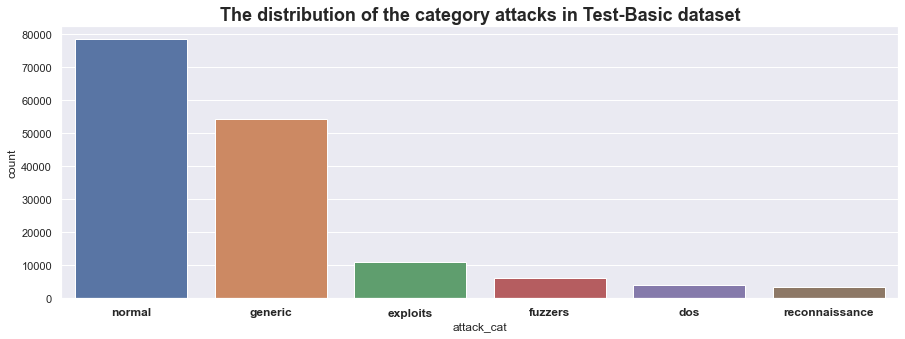

In [26]:
# Plotting attack category distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(basic_test['attack_cat'], order = basic_test['attack_cat'].value_counts().index)
plt.title('The distribution of the category attacks in Test-Basic dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [27]:
basic_test['attack_cat'].value_counts()

normal            78390
generic           54138
exploits          11047
fuzzers            6073
dos                4101
reconnaissance     3547
Name: attack_cat, dtype: int64

# UNSW-NB15-Test+

In [28]:
# Creating the Test+ dataset
test_plus = pd.concat([normal, analysis, backdoor, fuzzers, shellcode, worms])

In [29]:
# Balancing the dataset to obtain 50/50% attacks/normal traffic
test_plus=balance_dataset(test_plus)

In [30]:
all_0, all_1 = test_plus['label'].value_counts()[0]*100 / len(test_plus.index), test_plus['label'].value_counts()[1]*100 / len(test_plus.index)

print("In Basic dataset: there are {} % of normal traffic and {} % of attacks".format(all_0, all_1))

In Basic dataset: there are 50.0 % of normal traffic and 50.0 % of attacks


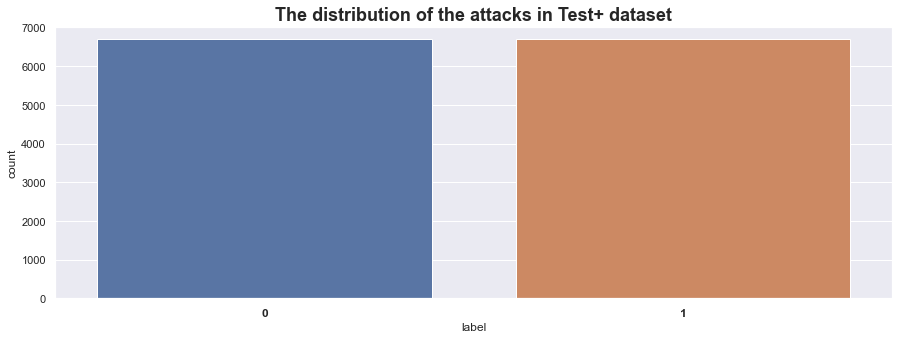

In [31]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(test_plus['label'])
plt.title('The distribution of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

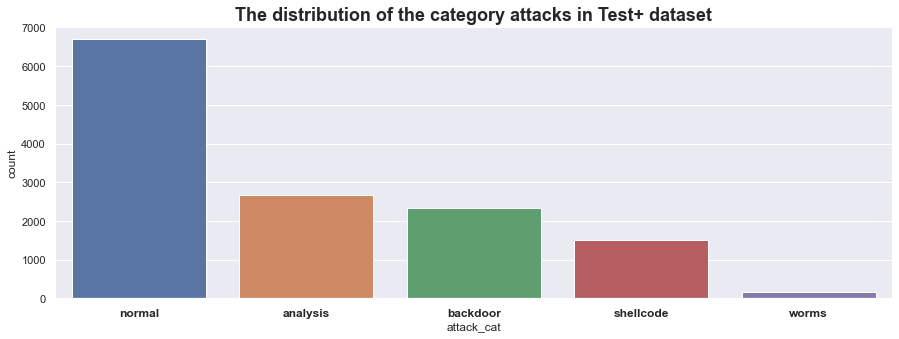

In [32]:
# Plotting attack category distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(test_plus['attack_cat'], order = test_plus['attack_cat'].value_counts().index)
plt.title('The distribution of the category attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [33]:
test_plus['attack_cat'].value_counts()

normal       6691
analysis     2677
backdoor     2329
shellcode    1511
worms         174
Name: attack_cat, dtype: int64

# UNSW-NB15-Test

In [6]:
# Creating the UNSW-NB15-Test dataset
test=balance_dataset(data)

In [7]:
all_0, all_1 = test['label'].value_counts()[0]*100 / len(test.index), test['label'].value_counts()[1]*100 / len(test.index)

print("In Basic dataset: there are {} % of normal traffic and {} % of attacks".format(all_0, all_1))

In Basic dataset: there are 50.0 % of normal traffic and 50.0 % of attacks


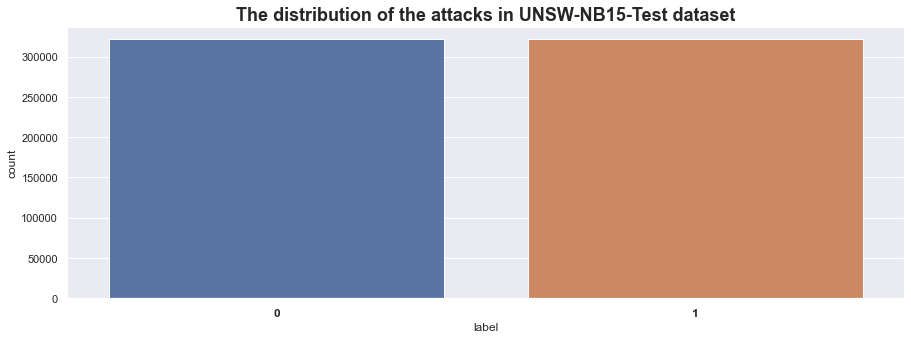

In [9]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(test['label'])
plt.title('The distribution of the attacks in UNSW-NB15-Test dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

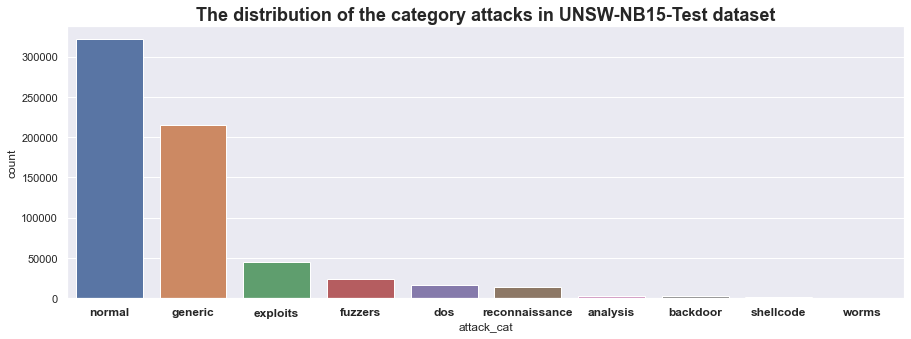

In [10]:
# Plotting attack category distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(test['attack_cat'], order = test['attack_cat'].value_counts().index)
plt.title('The distribution of the category attacks in UNSW-NB15-Test dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [ ]:
test['attack_cat'].value_counts()

normal            321283
generic           215481
exploits           44525
fuzzers            24246
dos                16353
reconnaissance     13987
analysis            2677
backdoor            2329
shellcode           1511
worms                174
Name: attack_cat, dtype: int64

In [ ]:
# Exporting the generated datasets
basic.to_csv('../datasets/UNSW-NB15-Basic.csv', index=False)
basic_train.to_csv('../datasets/UNSW-NB15-Train-Basic.csv', index=False)
basic_test.to_csv('../datasets/UNSW-NB15-Test-Basic.csv', index=False)
test_plus.to_csv('../datasets/UNSW-NB15-Test+.csv', index=False)
test.to_csv('../datasets/UNSW-NB15-Test.csv', index=False)